# LeNet 5

En este Notebook se va a implementar la red convolucional **LeNet 5** en el dataset de nubes creado anteriormente.

In [180]:
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
from print_confusion_matrix import print_confusion_matrix

import numpy as np
import pandas as pd
import sklearn.utils
import matplotlib.pyplot as plt

%matplotlib inline

## Formatear el dataset
Primero cargamos los datos desde el disco

In [181]:
cloud_pd = joblib.load('data/clouds.pkl')

Se cuentan los datos que tenemos por cada clase para ver la cantidad que hay de cada uno.

In [182]:
cloud_pd.groupby(by='cloud_type').cloud_type.count()

cloud_type
altocumulos        1729
altostratos        1727
cirros              660
estratocumulos     1743
sky               14109
Name: cloud_type, dtype: int64

Hay pocos datos de cirros, por lo que sería necesario aumentar el numero de datos de esta clase creando imagenes sinteticas de las disponibles. Ademas hay un gran numero de muestras de la clase **sky** con respecto a las demas.

En la siguiente celda se borra esta clase, pues no tiene mucho sentido introducirla en la clasificación. Pues es facilmente diferenciable con el preprocesado que se hizo con los patches en el notebook anterior.

In [183]:
cloud_pd = cloud_pd[cloud_pd.cloud_type != 'sky']

Hacemos data augmentation utilizando **flip** y **rotacion**

In [206]:
from imutils import augmentation
import random

cirros_pd = cloud_pd[cloud_pd.cloud_type == 'cirros']
cirros = cirros_pd.iloc[:, 2:].values
cirros_date = cirros_pd.datestr
cirros = cirros.reshape((-1, 32, 32, 3)).astype(np.uint8)

cirros_pd = pd.DataFrame(columns=['cloud_type', 'datestr', *range(32*32*3)])
row = pd.Series(['cirros', d, *np.random.rand(32*32*3)],
                index=['cloud_type', 'datestr', *range(32*32*3)])
for (d, c) in zip(cirros_date, cirros):
    row.datestr = d
    
    row[2:] = augmentation.flip_img(c, random.randint(0,1)).flatten()
    cirros_pd = cirros_pd.append(row, ignore_index=True)
    
    row[2:] = augmentation.rot90_img(c, random.randint(0,1)).flatten()
    cirros_pd = cirros_pd.append(row, ignore_index=True)

print(cirros_pd.shape)

(1320, 3074)

In [209]:
cloud_pd = cloud_pd.append(cirros_pd)
cloud_pd = sklearn.utils.shuffle(cloud_pd)

cloud_pd.groupby(by='cloud_type').cloud_type.count()

cloud_type
altocumulos       1729
altostratos       1727
cirros            1980
estratocumulos    1743
Name: cloud_type, dtype: int64

Crear una lookup_table con las etiquetas de las nubes y generar sus indices para el dataset.

In [210]:
cloud_lookup_table, cloud_pd.cloud_type = np.unique(cloud_pd.cloud_type.values,
                                                    return_inverse=True)

print('- Clouds Lookup-table: ', cloud_lookup_table)

- Clouds Lookup-table:  ['altocumulos' 'altostratos' 'cirros' 'estratocumulos']


Dividimos el dataset en sets de train y test.

In [211]:
batchsize = 32
nData = cloud_pd.shape[0]
nData_training = int(nData * 2/3)

# Batches number for training
batches = int(nData_training / batchsize)
nData_training = batches * batchsize
nData_testing = nData - nData_training

print('- Number Data training: {}'.format(nData_training))
print('- Number batches: {}'.format(batches))
print('- Number Data testing: {}'.format(nData_testing))

- Number Data training: 4768
- Number batches: 149
- Number Data testing: 2411


In [212]:
cloud_x = cloud_pd.iloc[:nData_training, 2:]
cloud_y = cloud_pd.iloc[:nData_training, 0]

cloud_test_x = cloud_pd.iloc[nData_training:, 2:]
cloud_test_y = cloud_pd.iloc[nData_training:, 0]

Importar paquetes necesarios de **pyTorch** y convertir los datos a tensores.

In [213]:
from torch.autograd import Variable

import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F

In [214]:
# Training
cloud_x = cloud_x.values.reshape((batches, batchsize, 
                                  32, 32, 3)).astype('uint8')
cloud_x = np.transpose(cloud_x, axes=(0, 1, 4, 2, 3))

cloud_y = cloud_y.values.reshape((batches, batchsize))

# Testing
cloud_test_x = cloud_test_x.values.reshape((cloud_test_x.shape[0],
                                            32, 32, 3)).astype('uint8')
cloud_test_x = np.transpose(cloud_test_x, axes=(0, 3, 1, 2))

cloud_test_y = cloud_test_y.values

# Convert to tensors
cloud_x = Variable(torch.Tensor(cloud_x).contiguous().cuda())
cloud_y = Variable(torch.LongTensor(cloud_y).contiguous().cuda())
cloud_test_x = Variable(torch.Tensor(cloud_test_x).contiguous().cuda())

print('- Cloud_x {}'.format(cloud_x.shape))
print('- Cloud_y {}'.format(cloud_y.shape))
print('- Cloud_test_x {}'.format(cloud_test_x.shape))
print('- Cloud_test_y {}'.format(cloud_test_y.shape))

- Cloud_x torch.Size([149, 32, 3, 32, 32])
- Cloud_y torch.Size([149, 32])
- Cloud_test_x torch.Size([2411, 3, 32, 32])
- Cloud_test_y (2411,)


En este paso se normaliza el dataset

In [215]:
cloud_x = F.normalize(cloud_x, dim=2)
cloud_test_x = F.normalize(cloud_test_x, dim=1)

## Definir la red neuronal

A partir de este punto, se va a definir la arquitecture de **LeNet-5**. Tal y como se muestra en la imagen de abajo, la red esta formada por 2 capas de convolución con un filtro de tamaño (5x5) seguidas de maxpooling (2,2) y 3 capas ocultas fully connected al final.

![Architecture of LeNet-5](https://www.researchgate.net/profile/Vladimir_Golovko3/publication/313808170/figure/fig3/AS:552880910618630@1508828489678/Architecture-of-LeNet-5.ppm)

In [225]:
class LeNet(nn.Module):
    
    def __init__(self):
        super(LeNet, self).__init__()
        # First convolutional layer, 6 channels, kernel 5x5
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        
        # Second convolutional layer, 16 channels, kernel 5x5
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        
        # Dropout 0.5
        self.drop = nn.Dropout(0.3)
        
        # Fully connected
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(cloud_lookup_table))
        
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        
    def forward(self, x):
        b_size = x.size(0)

        # Max pooling (2,2)
        x = F.max_pool2d(F.relu(self.drop(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.drop(self.conv2(x))), (2, 2))
        x = x.view(b_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.log_softmax(x)
        
net = LeNet().cuda()
print(net)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (drop): Dropout(p=0.3)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)


In [226]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.03)
loss_function = F.nll_loss
success_history = list()

import time

start = time.time()

for epoch in range(100):
    net.train()
    
    # Training
    for idx in range(cloud_x.shape[0]):
        batch = cloud_x[idx]
        target = cloud_y[idx]
        optimizer.zero_grad() # set to zero gradient buffers
        output = net.forward(batch)
        loss = loss_function(output, target)
        loss.backward() # compute gradients
        optimizer.step() # do the update
        
    # Testing  
    net.eval()
    
    output_test = np.argmax(net(cloud_test_x).data.cpu().numpy(), axis=1)
    success = (cloud_test_y == output_test)
    success_history.append(success.sum() / success.shape[0])
    
    print('[Epoch {}] Train loss: {} Test accuracy: {}'.format(epoch, loss, success_history[epoch]))
    
end = time.time()
print('\n- Time: ', end - start)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch 0] Train loss: 1.4259651899337769 Test accuracy: 0.2725010369141435
[Epoch 1] Train loss: 1.4612494707107544 Test accuracy: 0.29821650767316465
[Epoch 2] Train loss: 1.4536185264587402 Test accuracy: 0.32476150974699297
[Epoch 3] Train loss: 1.4555141925811768 Test accuracy: 0.2986312733305682
[Epoch 4] Train loss: 1.4651546478271484 Test accuracy: 0.30194939858979675
[Epoch 5] Train loss: 1.4563292264938354 Test accuracy: 0.29987557030277895
[Epoch 6] Train loss: 1.4415596723556519 Test accuracy: 0.30443799253421816
[Epoch 7] Train loss: 1.4566212892532349 Test accuracy: 0.3139776026545002
[Epoch 8] Train loss: 1.459898591041565 Test accuracy: 0.3164661965989216
[Epoch 9] Train loss: 1.4507144689559937 Test accuracy: 0.29572791372874324
[Epoch 10] Train loss: 1.4377249479293823 Test accuracy: 0.2990460389879718
[Epoch 11] Train loss: 1.4331004619598389 Test accuracy: 0.2948983824139361
[Epoch 12] Train loss: 1.4321964979171753 Test accuracy: 0.2965574450435504
[Epoch 13] Train 

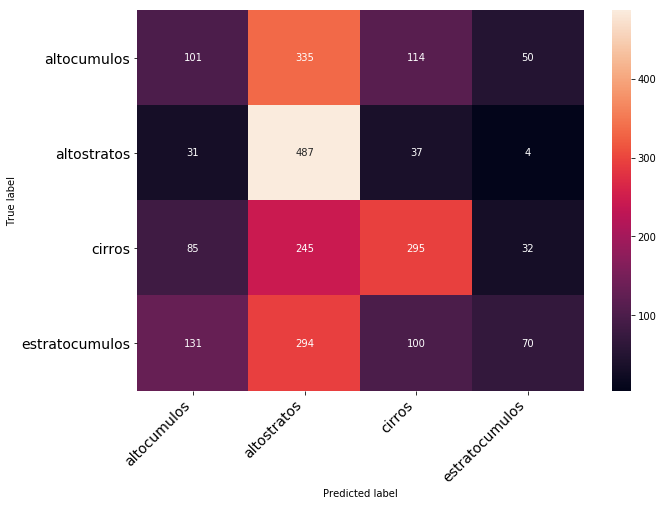

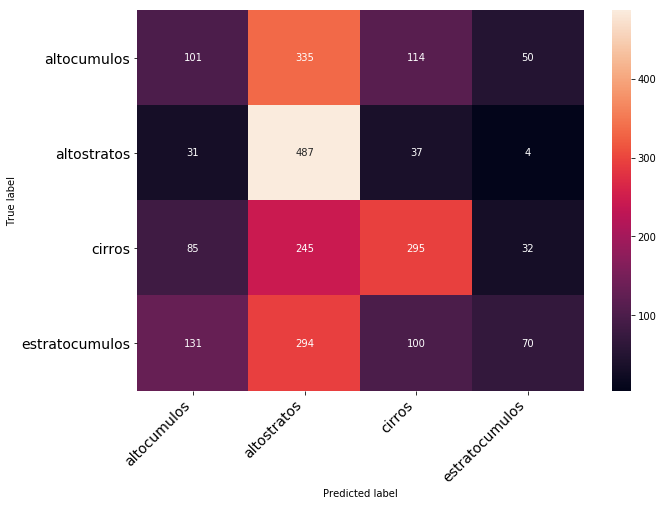

In [227]:
confusion = confusion_matrix(cloud_test_y, output_test)
print_confusion_matrix(confusion, cloud_lookup_table)